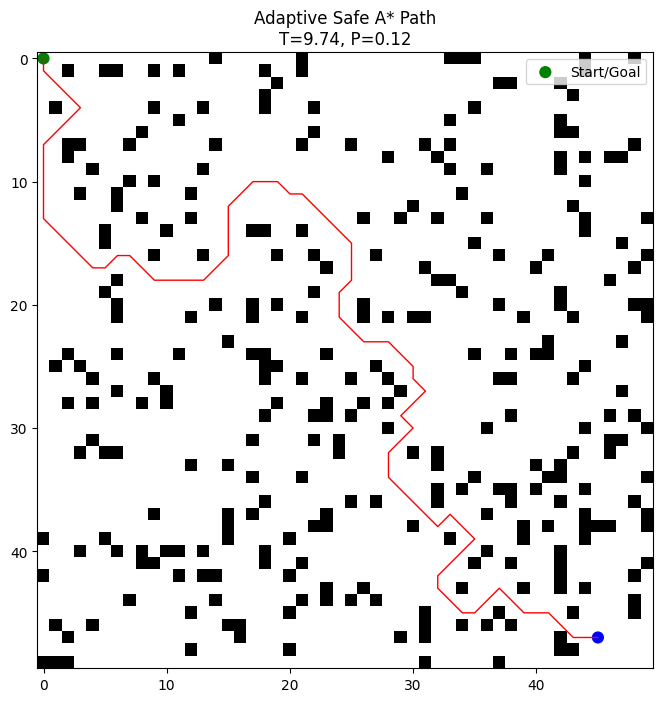

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import heapq
from math import sqrt, log

def compute_obstacle_density(grid): # Whole map
    SumZero = np.sum(grid == 0)
    SumOne = np.sum(grid == 1)

    total = SumOne + SumZero
    if total == 0:
        return 0.0

    return SumOne / total

def adaptive_weight_T(P):
    P = np.clip(P, 1e-6, 1 - 1e-6)
    return (1 - log(P))**2

def distance_to_nearest_obstacle(node, grid, max_range=10):
    x, y = node
    h, w = grid.shape
    min_dist = float("inf")
    for i in range(max(0, x - max_range), min(h, x + max_range + 1)):
        for j in range(max(0, y - max_range), min(w, y + max_range + 1)):
            if grid[i, j] == 1:
                d = sqrt((x - i)**2 + (y - j)**2)
                min_dist = min(min_dist, d)
    return min_dist if min_dist != float("inf") else None

def danger_coefficient(node, grid, max_range=10, beta=10):
    d = distance_to_nearest_obstacle(node, grid, max_range)
    if d is None:
        return 0.0
    return beta / (d + 1e-3)

def heuristic(a, b):
    return sqrt((a[0] - b[0])**2 + (a[1] - b[1])**2)

def neighbors(node, grid):
    dirs = [(1,0),(-1,0),(0,1),(0,-1),(1,1),(1,-1),(-1,1),(-1,-1)]
    res = []
    for dx, dy in dirs:
        nx, ny = node[0]+dx, node[1]+dy
        if 0 <= nx < grid.shape[0] and 0 <= ny < grid.shape[1] and grid[nx, ny] == 0:
            res.append((nx, ny))
    return res

def adaptive_safe_Astar(grid, start, goal, risk_penalty=100.0):
    P = compute_obstacle_density(grid)
    T = adaptive_weight_T(P)
    g = {start: 0}
    f = {start: heuristic(start, goal)}
    parent = {}
    openlist = [(f[start], start)]
    closed = set()

    while openlist:
        _, current = heapq.heappop(openlist)
        if current in closed:
            continue
        closed.add(current)
        if current == goal:
            # reconstruct path
            path = [current]
            while current in parent:
                current = parent[current]
                path.append(current)
            path.reverse()
            return path, T, P

        for nb in neighbors(current, grid):
            tentative_g = g[current] + heuristic(current, nb)
            D = danger_coefficient(nb, grid)
            f_nb = tentative_g + T * heuristic(nb, goal) + risk_penalty * D
            if nb not in g or tentative_g < g[nb]:
                g[nb] = tentative_g
                parent[nb] = current
                heapq.heappush(openlist, (f_nb, nb))

    return None, T, P

# Create Grid + obstacles
np.random.seed(34)              # kalo mau tiap generate berubah hapus ini
grid = np.zeros((50, 50))
start, goal = (0, 0), (47, 45)

num_obstacles = 300
placed = 0
h, w = grid.shape

while placed < num_obstacles:
    i = np.random.randint(h)
    j = np.random.randint(w)

    if (i, j) == start or (i, j) == goal: continue
    if grid[i, j] == 1: continue

    grid[i, j] = 1
    placed += 1

# algorithm start here
path, T, P = adaptive_safe_Astar(grid, start, goal)

# --- Plot for picture ---
plt.figure(figsize=(8, 8))
plt.imshow(grid, cmap="gray_r")
if path:
    px, py = zip(*path)
    plt.plot(py, px, 'r-', linewidth=1)
plt.scatter([start[1], goal[1]], [start[0], goal[0]], c=["green", "blue"], s=60, label="Start/Goal")
plt.title(f"Adaptive Safe A* Path\nT={T:.2f}, P={P:.2f}")
plt.legend()
plt.show()
